In [ ]:
%cd ..

In [2]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from omegaconf import DictConfig

%matplotlib inline

In [3]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [4]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

## 

In [5]:
# Augmentation
aug = Compose([CenterCrop(256, 256), ToTensor()])

In [8]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'
test_subjects = [1, 8, 11, 15]
cams = [2]

hparams = DictConfig({'data_dir': data_dir, 'save_split':False, 'labels_dir' : labels_dir, 'test_subjects':test_subjects, 'cams': cams})
params = get_dataset_params(hparams)

.npy|.mat


In [9]:
d = DHP3DDataset(params['file_paths'], labels_dir, params['test_indexes'], transform=aug)
loader = get_dataloader(d, 32, 2)

In [10]:
batch = next(iter(loader))
x, y = batch

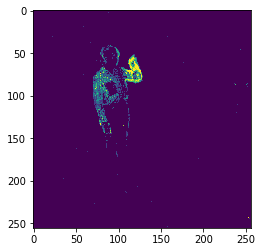

In [11]:
plt.imshow(x[1].squeeze())

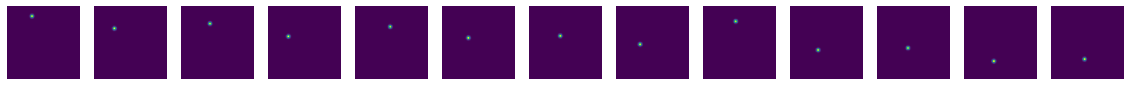

In [12]:
display(y[1].numpy())

## Loaded model for 2d heatmap prediction

In [16]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.models.dsnt import average_loss
from experimenting.utils import get_joints_from_heatmap

exp_name = 'exps_unet_resnet34/exp_SGD_0.01_randomcrop_hflip_aug_05-20-08-45'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.PoseEstimator.load_from_checkpoint(checkpoint_path)
model = model.eval()

In [17]:
loss = losses.PixelWiseLoss('mask_mean')

In [18]:
with torch.no_grad():
    preds = model(x)

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/nn/functional.py:2875: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [19]:
gt_joints, _ = get_joints_from_heatmap(y)
p_joints, p_conf = get_joints_from_heatmap(preds)

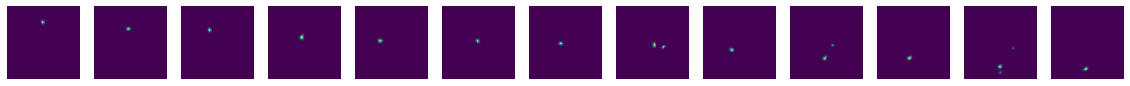

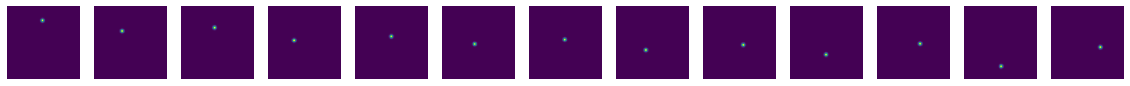

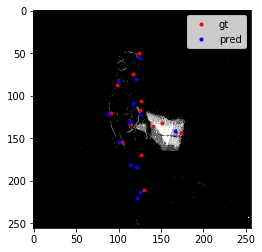

In [20]:
display(preds[2].numpy())
display(y[2].numpy())
plot_2d(x[2].squeeze(), gt_joints[2], p_joints[2])

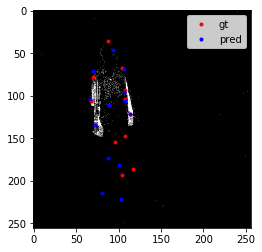

In [22]:
for i in range(0, 1):
    plot_2d(x[i].squeeze(), gt_joints[i], p_joints[i])

In [23]:
# Kornia based

In [24]:
import kornia

In [39]:
from kornia.geometry import dsnt
from kornia.geometry import *

In [194]:
joints = dsnt.spatial_expectation2d(preds, True)
mw = 255
my = 255

In [215]:
p = torch.zeros_like(gt_joints) # GT (can be loaded as list of coordinates, see kornia_dsnt)
p[:, :, 0] = p_joints[:, :, 1]
p[:, :, 1] = p_joints[:, :, 0]
p = p.type(torch.float)

In [195]:
joints[0]

tensor([[-0.2795, -0.6487],
        [-0.1763, -0.4556],
        [-0.4526, -0.4360],
        [-0.1627, -0.2499],
        [-0.4830, -0.1862],
        [-0.1576, -0.1594],
        [-0.2919, -0.1192],
        [-0.0973, -0.0451],
        [-0.4367,  0.0540],
        [-0.2422,  0.3066],
        [-0.2417,  0.4528],
        [-0.3436,  0.6742],
        [-0.1561,  0.7429]])

In [231]:
joints = dsnt.spatial_expectation2d(preds, True)
hm = render_gaussian2d(joints, torch.tensor([0.01, 0.01], dtype=torch.float), torch.tensor([255, 255]))

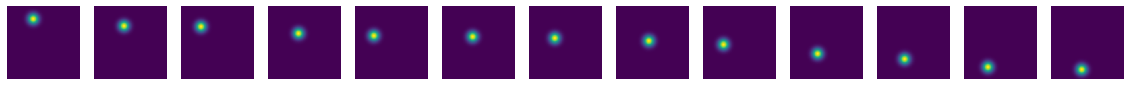

In [232]:
display(hm[0])

In [233]:
hm[0].max()

tensor(0.0010)

In [293]:
x = np.load('/data/dhp19/time_count_dataset/movements_per_frame/S1_session_1_mov_1_frame_10_cam_2.npy')
l1 = np.load('/data/dhp19/time_count_dataset/labels_joints/S1_session_1_mov_1_frame_10_cam_2_2dhm.npz')['joints']

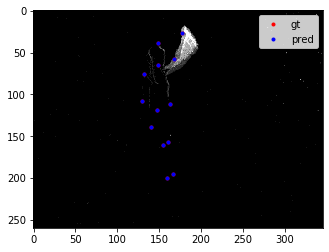

In [295]:
plot_2d(x.squeeze(),l1, l1)

In [345]:
l1_norm = normalize_pixel_coordinates(torch.tensor(l1), 342, 300 )
hm = render_gaussian2d(l1_norm, torch.tensor([0.001, 0.001], dtype=torch.float), torch.tensor([256, 256]))

In [365]:
l1_norm

tensor([[-0.7458, -0.1261],
        [-0.4983, -0.2258],
        [-0.5652, -0.1261],
        [-0.2776, -0.2375],
        [-0.6120, -0.0147],
        [-0.2040, -0.1378],
        [-0.2508, -0.0440],
        [-0.0702, -0.1789],
        [-0.8194,  0.0440],
        [ 0.0769, -0.0909],
        [ 0.0502, -0.0557],
        [ 0.3378, -0.0616],
        [ 0.3043, -0.0205]])

In [366]:
test = hm.unsqueeze(0) / hm.max()
joints = dsnt.spatial_expectation2d(hm, False)

ValueError: Invalid input shape, we expect BxCxHxW. Got: torch.Size([13, 256, 256])

In [404]:
sa = ConvSoftArgmax2d(output_value=True, normalized_coordinates=True)

In [408]:
nms_coords, nms_val = sa(preds)

In [409]:
nms_coords[0, 0, 0, -1, -1]

tensor(0.9961)

In [410]:
nms_coords[0, 0, 0, -1, -1]

tensor(0.9961)

In [412]:
joints = dsnt.spatial_expectation2d(preds, True)

In [415]:
denormalize_pixel_coordinates(joints, 342, 300)[0]

tensor([[107.7103,  59.9007],
        [123.1401,  92.8232],
        [ 81.8295,  96.1559],
        [125.1718, 127.8982],
        [ 77.2900, 138.7553],
        [125.9408, 143.3275],
        [105.8589, 150.1685],
        [134.9582, 162.8044],
        [ 84.2072, 179.7052],
        [113.2960, 222.7708],
        [113.3664, 247.7078],
        [ 98.1345, 285.4529],
        [126.1599, 297.1688]])